<a href="https://colab.research.google.com/github/pschofield2/machine_learning/blob/main/computer_vision_with_tensorflow_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Convolutional Neural Networks and Computer Vision with TensorFlow

Computer vision is the practice of writing algorithms which can discover patterns in visual data. Such as the camera of a self driving car recognizing the car in front.

## Get the data

The images we're working with are from the Food101 dataset (101 different classes of food): https://www.kaggle.com/dansbecker/food-101

However, we've modified it to only use two classes (pizza and steak)

>🔑 **Note:** we start with a smaller dataset so we can experiment quickly and figure out what works/doesn't work before scaling up

In [ ]:
import tensorflow as tf
import zipfile
import os
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import matplotlib.image as mpimg
import random
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import zipfile 
# Make the creating of our model a little easier
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential

In [ ]:
import zipfile 

# !wget means grab the file in the link and download it into google colab
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("pizza_steak.zip")
zip_ref.extractall()
zip_ref.close()

--2022-01-29 13:31:25--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.74.128, 209.85.147.128, 142.250.136.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.74.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109540975 (104M) [application/zip]
Saving to: ‘pizza_steak.zip’

pizza_steak.zip     100%[===================>] 104.47M   108MB/s    in 1.0s    

2022-01-29 13:31:26 (108 MB/s) - ‘pizza_steak.zip’ saved [109540975/109540975]



## Inspect the data (become one with it)

A very crucial step at the beginning of any machine learning project is becoming one with the data.

And for a computer vision project....this usually means visualizing many samples of your data

In [ ]:
#ls means list, ! allows user to execute commands from operating system in jupyter notebook
!ls pizza_steak 

test  train


In [ ]:
!ls pizza_steak/train/

pizza  steak


In [ ]:
!ls pizza_steak/train/steak

1000205.jpg  1647351.jpg  2238681.jpg  2824680.jpg  3375959.jpg  417368.jpg
100135.jpg   1650002.jpg  2238802.jpg  2825100.jpg  3381560.jpg  4176.jpg
101312.jpg   165639.jpg   2254705.jpg  2826987.jpg  3382936.jpg  42125.jpg
1021458.jpg  1658186.jpg  225990.jpg   2832499.jpg  3386119.jpg  421476.jpg
1032846.jpg  1658443.jpg  2260231.jpg  2832960.jpg  3388717.jpg  421561.jpg
10380.jpg    165964.jpg   2268692.jpg  285045.jpg   3389138.jpg  438871.jpg
1049459.jpg  167069.jpg   2271133.jpg  285147.jpg   3393547.jpg  43924.jpg
1053665.jpg  1675632.jpg  227576.jpg   2855315.jpg  3393688.jpg  440188.jpg
1068516.jpg  1678108.jpg  2283057.jpg  2856066.jpg  3396589.jpg  442757.jpg
1068975.jpg  168006.jpg   2286639.jpg  2859933.jpg  339891.jpg	 443210.jpg
1081258.jpg  1682496.jpg  2287136.jpg  286219.jpg   3417789.jpg  444064.jpg
1090122.jpg  1684438.jpg  2291292.jpg  2862562.jpg  3425047.jpg  444709.jpg
1093966.jpg  168775.jpg   229323.jpg   2865730.jpg  3434983.jpg  447557.jpg
1098844.jpg  1697

In [ ]:
import os

# Walk through the pizza_steak directory and list number of files
for dirpath, dirnames, filenames in os.walk("pizza_steak"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in 'pizza_steak'.
There are 2 directories and 0 images in 'pizza_steak/train'.
There are 0 directories and 750 images in 'pizza_steak/train/pizza'.
There are 0 directories and 750 images in 'pizza_steak/train/steak'.
There are 2 directories and 0 images in 'pizza_steak/test'.
There are 0 directories and 250 images in 'pizza_steak/test/pizza'.
There are 0 directories and 250 images in 'pizza_steak/test/steak'.


In [ ]:
# Another way to find out how many images are in a file
num_steak_images_train = len(os.listdir("pizza_steak/train/steak"))

num_steak_images_train

750

To visualize our images, first let's get the class names programmatically.

In [ ]:
# Get the class names programmatically
import pathlib
import numpy as np
data_dir = pathlib.Path("pizza_steak/train") # turn into Path object
class_names = np.array(sorted(item.name for item in data_dir.glob("*"))) # create a list of class names from the subdirectories
print(class_names)

['pizza' 'steak']


In [ ]:
# Let's visualize our images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir,target_class):
  # Setup the target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder),1)
  print(random_image)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image
  return img

['579691.jpg']
Image shape: (287, 512, 3)


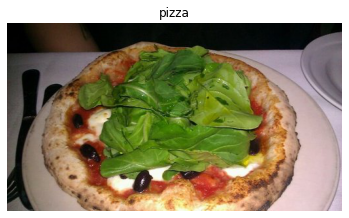

In [ ]:
# View random image from training dataset
img = view_random_image(target_dir="pizza_steak/train/",
                        target_class="pizza")

In [ ]:
import tensorflow as tf
tf.constant(img)

<tf.Tensor: shape=(287, 512, 3), dtype=uint8, numpy=
array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  3,   2,   7],
        [  3,   2,   7],
        [  3,   2,   7]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  3,   2,   7],
        [  3,   2,   7],
        [  3,   2,   7]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  1,   2,   4],
        [  2,   1,   6],
        [  2,   1,   6]],

       ...,

       [[ 92,  85,  79],
        [ 90,  83,  77],
        [ 90,  83,  77],
        ...,
        [203, 182, 199],
        [206, 185, 202],
        [203, 182, 199]],

       [[ 87,  82,  76],
        [ 82,  77,  71],
        [ 82,  77,  71],
        ...,
        [204, 183, 200],
        [207, 186, 203],
        [204, 183, 200]],

       [[ 88,  85,  78],
        [ 87,  84,  77],
        [ 87,  84,  77],
        ...,
        [203, 182, 19

In [ ]:
# View the image shape
img.shape # returns width, height colour channels

(287, 512, 3)

🔑**Note:** As we've discussed before, many machine learning models, including neural networks, prefer the values they work with to be between 0 and 1. Knowing this, one of the most common preprocessing steps for working with images is to scale (also referred to as normalize) their pixel values by dividing the image arrays by 255 (since 255 is the max pixel value).

## An end-to-end example

Let's build a convolutional neural network to find patterns in our images, more specifically we need a way to:

* Load our images
* Preprocess our images
* Build a CNN to find patterns in our images
* Compile our CNN
* Fit the CNN to our training data

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# set seed
tf.random.set_seed(42)

# preprocess data (get all pixel values between 0 and 1, also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Setup paths to our data directories
train_dir = "/content/pizza_steak/train"
test_dir = "pizza_steak/test"

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(directory = train_dir,
                                               batch_size=32,
                                               target_size=(224,224),
                                               class_mode="binary",
                                               seed=42)

valid_data = valid_datagen.flow_from_directory(directory=test_dir,
                                               batch_size=32,
                                               target_size=(224,224),
                                               class_mode="binary",
                                               seed=42)

# Build a CNN model (same as Tiny VGG on the CNN Explainer website)
model_1 = tf.keras.models.Sequential([
                                      tf.keras.layers.Conv2D(filters=10,
                                                             kernel_size=3,
                                                             activation="relu",
                                                             input_shape = (224,224,3)),
                                      tf.keras.layers.Conv2D(10,3,activation="relu"),
                                      tf.keras.layers.MaxPool2D(pool_size=2,
                                                                padding="valid"),
                                      tf.keras.layers.Conv2D(10,3,activation="relu"),
                                      tf.keras.layers.Conv2D(10,3,activation="relu"),
                                      tf.keras.layers.MaxPool2D(2),
                                      tf.keras.layers.Flatten(),
                                      tf.keras.layers.Dense(1,activation="sigmoid")
])

# compile our CNN
model_1.compile(loss="binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1 = model_1.fit(train_data, # data and labels both exist in this object which is why only train_data is passed
                       epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data = valid_data,
                        validation_steps = len(valid_data))

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/5
47/47 [==============================] - 16s 318ms/step - loss: 0.5519 - accuracy: 0.6973 - val_loss: 0.3631 - val_accuracy: 0.8460
Epoch 2/5
47/47 [==============================] - 13s 257ms/step - loss: 0.4068 - accuracy: 0.8153 - val_loss: 0.3397 - val_accuracy: 0.8740
Epoch 3/5
47/47 [==============================] - 12s 260ms/step - loss: 0.3776 - accuracy: 0.8387 - val_loss: 0.3024 - val_accuracy: 0.8620
Epoch 4/5
47/47 [==============================] - 12s 261ms/step - loss: 0.3737 - accuracy: 0.8320 - val_loss: 0.3581 - val_accuracy: 0.8640
Epoch 5/5
47/47 [==============================] - 12s 260ms/step - loss: 0.3246 - accuracy: 0.8680 - val_loss: 0.3343 - val_accuracy: 0.8540


>🔑**Note:** if the above cell is taking longer than ~10 seconds per epoch, make sure you're using a GPU by going to RunTime -> Change Runtime Type -> Hardware Accelerator -> GPU (you may have to re-run some cells above).

In [ ]:
len(train_data)

47

In [ ]:
1500/32 #1500 images divided by 32 batches = ~47 which correspnds to len(train_data)

46.875

In [ ]:
# Get a summary
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 10)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 10)       0         
 2D)                                                    

## Using the same model as before

Let's replicate the model we've built in a previous section to see if it works with our image data.

The model we're building is from the tensorflow playground

In [ ]:
# set random seed
tf.random.set_seed(42)

# Create a model to replicate the TensorFlow Playground model
model_2 = tf.keras.Sequential([
                               tf.keras.layers.Flatten(input_shape=(224,224,3)),
                               tf.keras.layers.Dense(4, activation="relu"),
                               tf.keras.layers.Dense(4,activation="relu"),
                               tf.keras.layers.Dense(1,activation="sigmoid")
])

# compile the model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# fit the model
history_2 = model_2.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Epoch 1/5
47/47 [==============================] - 22s 408ms/step - loss: 1.0408 - accuracy: 0.4920 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/5
47/47 [==============================] - 16s 338ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/5
47/47 [==============================] - 10s 217ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/5
47/47 [==============================] - 10s 214ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/5
47/47 [==============================] - 10s 214ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000


In [ ]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 150528)            0         
                                                                 
 dense_1 (Dense)             (None, 4)                 602116    
                                                                 
 dense_2 (Dense)             (None, 4)                 20        
                                                                 
 dense_3 (Dense)             (None, 1)                 5         
                                                                 
Total params: 602,141
Trainable params: 602,141
Non-trainable params: 0
_________________________________________________________________


Despite having 20x more params than our CNN (model_1), model_2 performs terribly. Let's try to improve it.

In [ ]:
# set random seed
tf.random.set_seed(42)

# create model
model_3 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(224,224,3)),
    tf.keras.layers.Dense(100,activation="relu"),
    tf.keras.layers.Dense(100,activation="relu"),
    tf.keras.layers.Dense(100,activation="relu"),
    tf.keras.layers.Dense(1,activation="sigmoid")
])

# compile the model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# fit the model
history_3 = model_3.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Epoch 1/5
47/47 [==============================] - 12s 235ms/step - loss: 4.3355 - accuracy: 0.5867 - val_loss: 0.7318 - val_accuracy: 0.7360
Epoch 2/5
47/47 [==============================] - 11s 229ms/step - loss: 0.5950 - accuracy: 0.7293 - val_loss: 0.5506 - val_accuracy: 0.7260
Epoch 3/5
47/47 [==============================] - 11s 226ms/step - loss: 0.7921 - accuracy: 0.6807 - val_loss: 0.8641 - val_accuracy: 0.5880
Epoch 4/5
47/47 [==============================] - 11s 225ms/step - loss: 0.5735 - accuracy: 0.7427 - val_loss: 0.4391 - val_accuracy: 0.7780
Epoch 5/5
47/47 [==============================] - 11s 226ms/step - loss: 0.4679 - accuracy: 0.7880 - val_loss: 0.4629 - val_accuracy: 0.7700


In [ ]:
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 150528)            0         
                                                                 
 dense_4 (Dense)             (None, 100)               15052900  
                                                                 
 dense_5 (Dense)             (None, 100)               10100     
                                                                 
 dense_6 (Dense)             (None, 100)               10100     
                                                                 
 dense_7 (Dense)             (None, 1)                 101       
                                                                 
Total params: 15,073,201
Trainable params: 15,073,201
Non-trainable params: 0
_________________________________________________________________


In [ ]:
15000000/31000

483.8709677419355

🔑 **Note:** You can think of trainable params as **patterns a model can learn from the data.** Intuitively, you might think more is better. And in lots of cases, it is. But in this case, the difference here is the two different styles of model we're using. Whereas a series of dense layers has a number of different learnable params connected to each other and hence a higher numer of possible learnable patterns, **a convolutional neural network seeks to sort out and learn from the most important patterns in an image.** So even though these are less learnable params in our convolutional neural network, these are often more helpful in deciphering between different features in an image.

In [ ]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 10)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 10)       0         
 2D)                                                    

## Binary Classification: Let's Break it Down

1. Become one with the data (visualize, visualize, visualize)
2. Preprocess the data (prepare it for our model, the main step here was scaling/normalizing & turning our data into batches)
3. Create a model (start with a baseline)
4. Fit the model
5. Evaluate the model
6. Adjust different parameters and improve the model (try to beat our baseline)
7. Repeat until satisfied (experiment, experiment, experiment).

###1. Become one with the data

['2818805.jpg']
Image shape: (384, 512, 3)
['214728.jpg']
Image shape: (512, 382, 3)


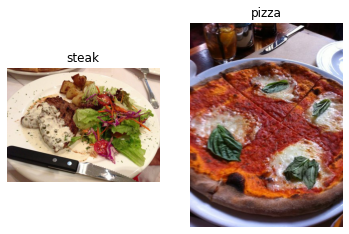

In [ ]:
# Visualize data
plt.figure()
plt.subplot(1,2,1)
steak_img = view_random_image("pizza_steak/train/","steak")
plt.subplot(1,2,2)
pizza_img = view_random_image("pizza_steak/train/","pizza")

###2. Preprocess the data (prepare it for our model)

In [ ]:
# Define directory dataset paths
train_dir = "pizza_steak/train/"
test_dir = "pizza_steak/test/"

Our next step is to turn our data into **batches (standard is batch size of 32)**.

A batch is a small subset of data. Rather than look at all ~10,000 images at one time, a model might only look at 32 at a time.

It does this for a couple reasons:
1. 10,000 images (or more) might not fit into the memory of your processor (GPU).
2. Trying to learn the patterns in 10,000 images in one hit could result in the model not being able to learn very well.



In [ ]:
# Create train and test data generators and rescale the data
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

In [ ]:
# Load in our image data from directories and turn them into batches
train_data = train_datagen.flow_from_directory(directory=train_dir, # target directory of images
                                               target_size=(224,224), # target size of images (height,width)
                                               class_mode="binary", # type of data you're working with
                                               batch_size=32) # size of minibatches to load data into
test_data = test_datagen.flow_from_directory(directory=test_dir,
                                             target_size=(224,224),
                                             class_mode="binary",
                                             batch_size=32)

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [ ]:
# Get a sample of a train data batch
images,labels = train_data.next() # get the "next" batch of images/labels in train_data
len(images), len(labels)

(32, 32)

In [ ]:
# how many batches are there?
len(train_data)

47

In [ ]:
1500/32

46.875

In [ ]:
# get the first two images
images[:2], images[0].shape

(array([[[[0.47058827, 0.40784317, 0.34509805],
          [0.4784314 , 0.427451  , 0.3647059 ],
          [0.48627454, 0.43529415, 0.37254903],
          ...,
          [0.8313726 , 0.70980394, 0.48627454],
          [0.8431373 , 0.73333335, 0.5372549 ],
          [0.87843144, 0.7725491 , 0.5882353 ]],
 
         [[0.50980395, 0.427451  , 0.36078432],
          [0.5058824 , 0.42352945, 0.35686275],
          [0.5137255 , 0.4431373 , 0.3647059 ],
          ...,
          [0.82745105, 0.7058824 , 0.48235297],
          [0.82745105, 0.70980394, 0.5058824 ],
          [0.8431373 , 0.73333335, 0.5372549 ]],
 
         [[0.5254902 , 0.427451  , 0.34901962],
          [0.5372549 , 0.43921572, 0.36078432],
          [0.5372549 , 0.45098042, 0.36078432],
          ...,
          [0.82745105, 0.7019608 , 0.4784314 ],
          [0.82745105, 0.7058824 , 0.49411768],
          [0.8352942 , 0.7176471 , 0.5137255 ]],
 
         ...,
 
         [[0.77647066, 0.5647059 , 0.2901961 ],
          [0.78039

In [ ]:
images[7], images[7].shape

(array([[[0.30588236, 0.17254902, 0.227451  ],
         [0.34901962, 0.21960786, 0.25490198],
         [0.4039216 , 0.2784314 , 0.2901961 ],
         ...,
         [0.16470589, 0.02745098, 0.1137255 ],
         [0.16862746, 0.01960784, 0.10980393],
         [0.15686275, 0.00784314, 0.10588236]],
 
        [[0.28235295, 0.14901961, 0.20392159],
         [0.34117648, 0.21176472, 0.24705884],
         [0.42352945, 0.29803923, 0.30980393],
         ...,
         [0.17254902, 0.02352941, 0.1137255 ],
         [0.1764706 , 0.02745098, 0.11764707],
         [0.16078432, 0.01176471, 0.10980393]],
 
        [[0.2627451 , 0.13725491, 0.19607845],
         [0.3254902 , 0.20000002, 0.24313727],
         [0.41960788, 0.29803923, 0.31764707],
         ...,
         [0.19215688, 0.04313726, 0.1254902 ],
         [0.1764706 , 0.02745098, 0.11764707],
         [0.16862746, 0.03137255, 0.1254902 ]],
 
        ...,
 
        [[0.62352943, 0.5803922 , 0.5568628 ],
         [0.6039216 , 0.56078434, 0.53725

In [ ]:
# View the first batch of labels
labels

array([1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
       1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1.],
      dtype=float32)

###3. Create a CNN model (start with a baseline)

A baseline is a relatively simple model or existing result that you setup when beginning a machine learning experiment and then as you keep experimenting, you try to beat the baseline.

>🔑**Note:** in deep learning, there is almost an infinite amount of architectures you could create. So one of the best ways to get started is to start with with something simplyand see if it works on your data and then introduce complexity as required.

In [ ]:
# Make the creating of our model a little easier
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential

In [ ]:
# Create the model (this will be our baseline, a 3 layer convolutional neural network)
model_4 = Sequential([
                      Conv2D(filters=10, # filters is the number of sliding windows going across an input (higher = more complex model)
                             kernel_size=3, # the size of the sliding window going across an input
                             strides=1,# the size of the step the sliding window takes across an input
                             padding="valid", # if same, output shape is same as input shape. if valid, output shape gets compressed
                             activation="relu",
                             input_shape=(224,224,3)), # input layer (specify input shape)
                      Conv2D(10,3,activation="relu"),
                      Conv2D(10,3,activation="relu"),
                      Flatten(),
                      Dense(1,activation="sigmoid") # output layer (working with binary classification so only 1 output neuron)
])

In [ ]:
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 conv2d_5 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 conv2d_6 (Conv2D)           (None, 218, 218, 10)      910       
                                                                 
 flatten_3 (Flatten)         (None, 475240)            0         
                                                                 
 dense_8 (Dense)             (None, 1)                 475241    
                                                                 
Total params: 477,341
Trainable params: 477,341
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# compile the model
model_4.compile(loss="binary_crossentropy",
                optimizer = Adam(),
                metrics=["accuracy"])

###4. Fit the model

In [ ]:
# Check the lengths of training and test data generators
len(train_data),len(test_data)

(47, 16)

In [ ]:
# Fit the model
history_4 = model_4.fit(train_data, #this is a combination of sample data and its labels
                        epochs=5,
                        steps_per_epoch = len(train_data),
                        validation_data = test_data,
                        validation_steps = len(test_data)
                        )

Epoch 1/5
47/47 [==============================] - 14s 266ms/step - loss: 1.1159 - accuracy: 0.6827 - val_loss: 0.4714 - val_accuracy: 0.7980
Epoch 2/5
47/47 [==============================] - 12s 253ms/step - loss: 0.4243 - accuracy: 0.8147 - val_loss: 0.3938 - val_accuracy: 0.8320
Epoch 3/5
47/47 [==============================] - 12s 250ms/step - loss: 0.2768 - accuracy: 0.8933 - val_loss: 0.4405 - val_accuracy: 0.8000
Epoch 4/5
47/47 [==============================] - 12s 255ms/step - loss: 0.1709 - accuracy: 0.9407 - val_loss: 0.5234 - val_accuracy: 0.7860
Epoch 5/5
47/47 [==============================] - 12s 260ms/step - loss: 0.0581 - accuracy: 0.9887 - val_loss: 0.4686 - val_accuracy: 0.8000


### 5. Evaluating our model

It looks like our model is learning something, let's evaluate it.

In [ ]:
import pandas as pd # it's really easy to create a plot if you create a dataframe
pd.DataFrame(history_4.history).plot(figsize=(10,7))

NameError: ignored

In [ ]:
# Plot the validation and training curves separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"])) # how many epochs did we run for?


  # plot loss
  plt.plot(epochs,loss,label = "training_loss")
  plt.plot(epochs,val_loss,label = "val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend();

  #plot accuracy
  plt.figure()
  plt.plot(epochs,accuracy,label="training_accuracy")
  plt.plot(epochs,val_accuracy,label="val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend();

> 🔑 **Note:** when a model's validation loss starts to increase, it's likely that the model is **overfitting** the training dataset. This means it's learning the patterns in the training dataset *too* well, and thus the model's ability to generalize on unseen data will be diminished.

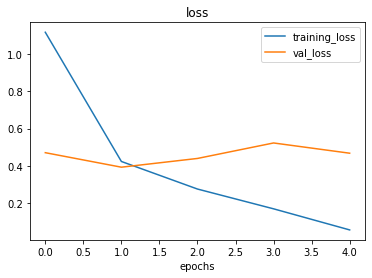

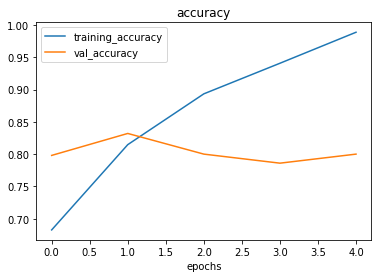

In [ ]:
plot_loss_curves(history_4)

### 6. Adjust the model parameters

Fitting a machine learning model comes in 3 steps:

0. Create a baseline
1. Beat the baseline by overfitting a larger model
2. Reduce over-fitting

Ways to induce overfitting:

* Increase the number of conv layers
* Increase the number of conv filters
* Add another dense layer to the output of the flattened layer

Ways to reduce overfitting:

* Add data augmentation
* Add regularization layers (such as MaxPool2D)
* Add more data...

> 🔑 **Note:** Reducing overfitting is also known as ***regularization***

In [ ]:
# Create the model (this is going to be our new baseline)
tf.random.set_seed(42)

model_5 = Sequential([
                      Conv2D(10,3,activation = "relu",input_shape=(224,224,3)),
                      MaxPool2D(pool_size=2),
                      Conv2D(10,3,activation="relu"),
                      MaxPool2D(),
                      Conv2D(10,3,activation="relu"),
                      MaxPool2D(),
                      Flatten(),
                      Dense(1,activation="sigmoid")
])

In [ ]:
# Compile the model
model_5.compile(loss="binary_crossentropy",
                optimizer=Adam(),
                metrics=["accuracy"])

In [ ]:
# fit the model
history_5 = model_5.fit(train_data,
                        epochs=5,
                        steps_per_epoch = len(train_data),
                        validation_data=test_data,
                        validation_steps = len(test_data))

Epoch 1/5
47/47 [==============================] - 19s 372ms/step - loss: 0.6197 - accuracy: 0.6473 - val_loss: 0.4886 - val_accuracy: 0.7600
Epoch 2/5
47/47 [==============================] - 18s 379ms/step - loss: 0.4657 - accuracy: 0.7787 - val_loss: 0.3737 - val_accuracy: 0.8340
Epoch 3/5
47/47 [==============================] - 18s 383ms/step - loss: 0.4159 - accuracy: 0.8140 - val_loss: 0.3469 - val_accuracy: 0.8400
Epoch 4/5
47/47 [==============================] - 17s 357ms/step - loss: 0.4062 - accuracy: 0.8207 - val_loss: 0.3152 - val_accuracy: 0.8880
Epoch 5/5
47/47 [==============================] - 19s 404ms/step - loss: 0.3752 - accuracy: 0.8387 - val_loss: 0.3812 - val_accuracy: 0.8120


In [ ]:
# get a summary of our model with max pooling
model_5.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 111, 111, 10)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 109, 109, 10)      910       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 54, 54, 10)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 52, 52, 10)        910       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 26, 26, 10)      

In [ ]:
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 conv2d_5 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 conv2d_6 (Conv2D)           (None, 218, 218, 10)      910       
                                                                 
 flatten_3 (Flatten)         (None, 475240)            0         
                                                                 
 dense_8 (Dense)             (None, 1)                 475241    
                                                                 
Total params: 477,341
Trainable params: 477,341
Non-trainable params: 0
_________________________________________________________________


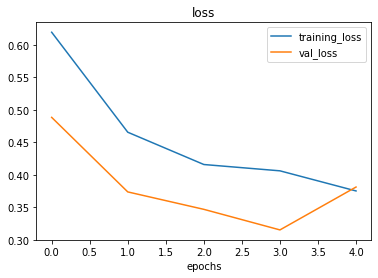

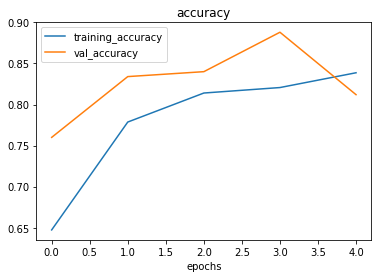

In [ ]:
plot_loss_curves(history_5)

### Opening our bag of tricks and finding data augmentation

In [ ]:
# Create ImageDataGenerator training instance with data augmentation
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                          rotation_range=20,# how much do you want to rotate an image?
                                          shear_range=0.2, # how much do you want to shear an image?
                                          zoom_range=0.2, #zoom in randomly on an image
                                          width_shift_range=0.2, #move image around on x axis
                                          height_shift_range=0.3,# move image around on y axis
                                          horizontal_flip=True) # do you want to flip an image?

# Create ImageDataGenerator without data augmentation
train_datagen = ImageDataGenerator(rescale=1/255.)

# Create ImageDataGenerator without data augmentation for the test dataset
test_datagen = ImageDataGenerator(rescale=1/255.)

> 🤔 **Question:** What is data augmentation?

Data augmentation is the process of altering our training data, leading it to have more diversity and in turn allowing our models to learn more generalizable (hopefully) patterns. Altering might mean adjusting the rotation of an image, flipping it, cropping it, or something similar.

Increases diversity of training dataset without collecting more data.

Let's write some code to visualize data augmentation...


In [ ]:
# Import data and augment it from training director
print("Augmented training images")
train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                               target_size=(224,224),
                                                               batch_size=32,
                                                               class_mode="binary",
                                                               shuffle=False) # for demonstration purposes only

# Create non-augmented train data batches
print("Non Augmented Training Images")
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224,224),
                                               class_mode = "binary",
                                               batch_size=32,
                                               shuffle=False)

IMG_SIZE = (224,224)

# Create non-augmented test data batches
print("Non-augmented test data:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMG_SIZE,
                                             batch_size=32,
                                             class_mode="binary")

Augmented training images
Found 1500 images belonging to 2 classes.
Non Augmented Training Images
Found 1500 images belonging to 2 classes.
Non-augmented test data:
Found 500 images belonging to 2 classes.


> 🔑 **Note:** Data augmentation is usually only performed on the training data. Using `ImageDataGenerator` built-in data augmentation parameters our images are left as they are in the directories but are modified as they're loaded into the model.

Finally....let's visualize some augmented data!!!

In [ ]:
# Get sample data batches
images, labels = train_data.next()

augmented_images, augmented_labels = train_data_augmented.next() # note: labels aren't augmented

Showing image number 22


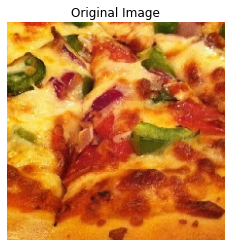

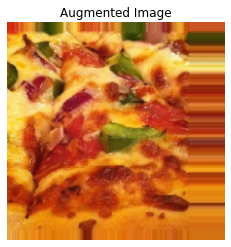

In [ ]:
# Show original image and augmented image
import random
random_number = random.randint(0,31) # our batch size is 32
print(f"Showing image number {random_number}")
plt.imshow(images[random_number])
plt.title(f"Original Image")
plt.axis(False)
plt.figure()
plt.imshow(augmented_images[random_number])
plt.title(f"Augmented Image")
plt.axis(False);

Now we've seen what augmented data looks like, let's build a model and see how it performs

In [ ]:
# set seed
# tf.random.set_seed(42)

# create model
model_6 = Sequential([
                      Conv2D(10,3,activation="relu",input_shape=(224,224,3)),
                      MaxPool2D(pool_size=2),
                      Conv2D(10,3,activation="relu"),
                      MaxPool2D(),
                      Conv2D(10,3,activation="relu"),
                      MaxPool2D(),
                      Flatten(),
                      Dense(1,activation="sigmoid")
])

# Compile model
model_6.compile(loss="binary_crossentropy",
                optimizer=Adam(),
                metrics=["accuracy"])

# fit the model
history_6 = model_6.fit(train_data_augmented,
                        epochs=5,
                        steps_per_epoch=len(train_data_augmented),
                        validation_data = test_data,
                        validation_steps=len(test_data))

Epoch 1/5
47/47 [==============================] - 40s 590ms/step - loss: 0.6998 - accuracy: 0.5113 - val_loss: 0.6858 - val_accuracy: 0.6640
Epoch 2/5
47/47 [==============================] - 25s 542ms/step - loss: 0.6914 - accuracy: 0.5653 - val_loss: 0.7059 - val_accuracy: 0.5000
Epoch 3/5
47/47 [==============================] - 25s 533ms/step - loss: 0.6790 - accuracy: 0.5713 - val_loss: 0.6515 - val_accuracy: 0.7600
Epoch 4/5
47/47 [==============================] - 26s 550ms/step - loss: 0.6631 - accuracy: 0.6260 - val_loss: 0.5896 - val_accuracy: 0.7620
Epoch 5/5
47/47 [==============================] - 25s 532ms/step - loss: 0.6700 - accuracy: 0.6307 - val_loss: 0.6163 - val_accuracy: 0.5600


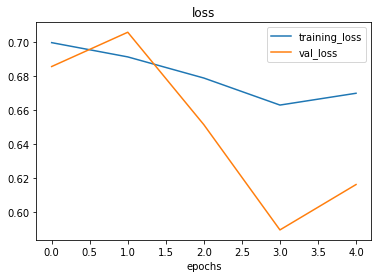

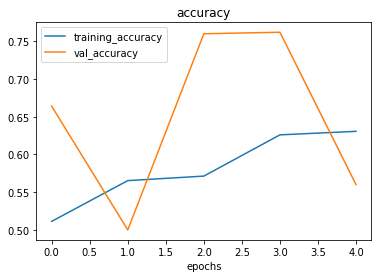

In [ ]:
# Check our models training curves
plot_loss_curves(history_6)

Let's shuffle our augmented training data and train another model (the same as before) on it and see what happens


In [ ]:
# Import data and augment it and shuffle it from training directory
train_data_augmented_shuffled = train_datagen_augmented.flow_from_directory(train_dir,
                                                                            target_size=(224,224),
                                                                            class_mode="binary",
                                                                            batch_size=32,
                                                                            shuffle=True) # shuffle data this time

Found 1500 images belonging to 2 classes.


In [ ]:
tf.random.set_seed(42)
# Create the model (same as model 5 and model 6)
model_7 = Sequential([
                      Conv2D(10,3,activation="relu",input_shape=(224,224,3)),
                      #Conv2D(10,3,activation="relu"),
                      MaxPool2D(),
                      Conv2D(10,3,activation="relu"),
                      #Conv2D(10,3,activation="relu"),
                      MaxPool2D(),
                      Conv2D(10,3,activation="relu"),
                      Flatten(),
                      Dense(1,activation="sigmoid")

])

# compile model
model_7.compile(loss="binary_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

# fit the model
history_7 = model_7.fit(train_data_augmented_shuffled,
                        epochs=5,
                        steps_per_epoch=len(train_data_augmented_shuffled),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
47/47 [==============================] - 23s 486ms/step - loss: 0.6391 - accuracy: 0.6387 - val_loss: 0.5047 - val_accuracy: 0.7960
Epoch 2/5
47/47 [==============================] - 22s 476ms/step - loss: 0.5779 - accuracy: 0.7107 - val_loss: 0.4557 - val_accuracy: 0.7960
Epoch 3/5
47/47 [==============================] - 22s 479ms/step - loss: 0.5032 - accuracy: 0.7587 - val_loss: 0.4747 - val_accuracy: 0.7540
Epoch 4/5
47/47 [==============================] - 22s 477ms/step - loss: 0.4656 - accuracy: 0.7853 - val_loss: 0.3311 - val_accuracy: 0.8560
Epoch 5/5
47/47 [==============================] - 22s 479ms/step - loss: 0.4615 - accuracy: 0.7933 - val_loss: 0.3440 - val_accuracy: 0.8480


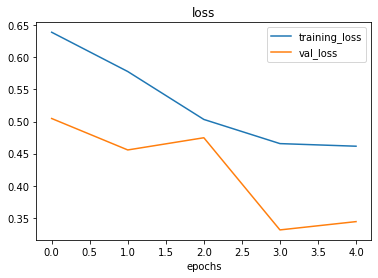

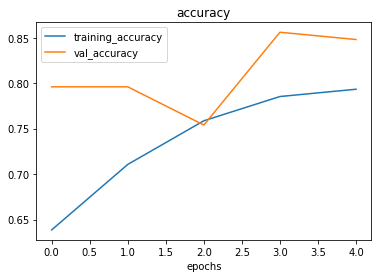

In [ ]:
#Plot loss curves
plot_loss_curves(history_7)

🔑**Note:** When shuffling training data, the model gets exposed to all different kinds of data during the training, thus enabling it to learn features across a wide array of images (in our case, pizza and steak at the same time instead of just pizza then steak)

### 7. Repeat until satisfied


Since we've already beaten our baseline, there are a few things we could try to continue to improve our model:

* Increase the number of model layers (e.g. add more `Conv2D` / `MaxPool2D` layers)
* Increase the number of filters in each convolutional layer (e.g. from 10 to 32 or even 64)
* Train for longer
* Find an ideal learning rate
* Get more data (give the model more opportunities to learn)
* Use **transfer learning** to leverage what another image model has learned and adjust it for our own use case

> 🛠 **Practice:** Recreate the model on the CNN explainer website (same as model_1) and see how it performs on shuffled training data.

## Making a prediction with our trained model on our own custom data

In [ ]:
# Classes we're working with
print(class_names)

['pizza' 'steak']


--2022-01-20 20:33:55--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1978213 (1.9M) [image/jpeg]
Saving to: ‘03-steak.jpeg’

03-steak.jpeg       100%[===================>]   1.89M  --.-KB/s    in 0.05s   

2022-01-20 20:33:56 (37.8 MB/s) - ‘03-steak.jpeg’ saved [1978213/1978213]



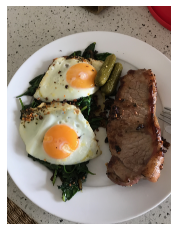

In [ ]:
# view our example image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg
steak = mpimg.imread("03-steak.jpeg")
plt.imshow(steak)
plt.axis(False);

In [ ]:
# Check the shape of our image
steak.shape

(4032, 3024, 3)

In [ ]:
steak

array([[[162, 158, 149],
        [163, 159, 150],
        [166, 162, 153],
        ...,
        [136,  17,  23],
        [140,  21,  27],
        [140,  21,  27]],

       [[164, 160, 151],
        [164, 160, 151],
        [164, 160, 151],
        ...,
        [133,  14,  20],
        [134,  15,  21],
        [137,  18,  24]],

       [[166, 162, 153],
        [165, 161, 152],
        [163, 159, 150],
        ...,
        [136,  17,  23],
        [134,  15,  21],
        [136,  17,  23]],

       ...,

       [[154, 132, 109],
        [142, 122,  98],
        [101,  80,  59],
        ...,
        [165, 154, 148],
        [152, 141, 135],
        [140, 129, 123]],

       [[141, 119,  95],
        [139, 117,  93],
        [106,  86,  62],
        ...,
        [158, 147, 141],
        [142, 131, 125],
        [138, 127, 121]],

       [[148, 127, 100],
        [149, 127, 103],
        [114,  94,  70],
        ...,
        [153, 142, 136],
        [138, 127, 121],
        [145, 132, 126]]

🔑**Note:** When you train a neural network and you want to make a prediction with it on your own custom data, it's important that your custom data (or new data) is preprocessed into the same format as the data your model was trained on.

In [ ]:
# Create a function to import and an image and resize it to be able to be used with our model

def load_and_prep_image(filename,img_shape=224):
  """
  Reads an image from filename, turns it into a tensor and reshapes
   it to (img_shape, img_shape, colour_channels).
   """

   # read in the image
  img = tf.io.read_file(filename)
   # Decode the read file into a tensor
  img = tf.image.decode_image(img)
   # Resize the image
  img = tf.image.resize(img, size = [img_shape,img_shape])
   # Rescale the image (get all values between 0 and 1)
  img = img / 255.
  return img

In [ ]:
# Load in and preprocess our custom image
steak = load_and_prep_image("03-steak.jpeg")
steak

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.6377451 , 0.6220588 , 0.57892156],
        [0.6504902 , 0.63186276, 0.5897059 ],
        [0.63186276, 0.60833335, 0.5612745 ],
        ...,
        [0.52156866, 0.05098039, 0.09019608],
        [0.49509802, 0.04215686, 0.07058824],
        [0.52843136, 0.07745098, 0.10490196]],

       [[0.6617647 , 0.6460784 , 0.6107843 ],
        [0.6387255 , 0.6230392 , 0.57598037],
        [0.65588236, 0.63235295, 0.5852941 ],
        ...,
        [0.5352941 , 0.06862745, 0.09215686],
        [0.529902  , 0.05931373, 0.09460784],
        [0.5142157 , 0.05539216, 0.08676471]],

       [[0.6519608 , 0.6362745 , 0.5892157 ],
        [0.6392157 , 0.6137255 , 0.56764704],
        [0.65637255, 0.6269608 , 0.5828431 ],
        ...,
        [0.53137255, 0.06470589, 0.08039216],
        [0.527451  , 0.06862745, 0.1       ],
        [0.52254903, 0.05196078, 0.0872549 ]],

       ...,

       [[0.49313724, 0.42745098, 0.31029412],
        [0.05

In [ ]:
pred = model_7.predict(tf.expand_dims(steak,axis=0))

Looks like our custom image is being put through our model,
however, it currently outputs a prediction probability,
wouldn't it be nice if we could visualize the image as well as the model's prediction?

In [ ]:
# remind ourselves of class names
class_names

array(['pizza', 'steak'], dtype='<U5')

In [ ]:
# We can index the predicted class by rounding the prediction probability and indexing it on the class names
pred_class = class_names[int(tf.round(pred))]
pred_class

'steak'

In [ ]:
def pred_and_plot(model,filename,class_names=class_names):
  """
  Imports an image located at filename, makes a prediction with model
  and plots the image with the predicted class as the title
  """

  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # make a prediction
  pred = model.predict(tf.expand_dims(img,axis=0))

  # Get the predicted class
  pred_class = class_names[int(tf.round(pred))]

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

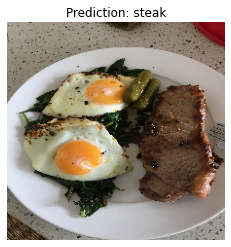

In [ ]:
# Test our model on a custom image
pred_and_plot(model_7,"03-steak.jpeg")

--2022-01-20 20:52:46--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2874848 (2.7M) [image/jpeg]
Saving to: ‘03-pizza-dad.jpeg’

03-pizza-dad.jpeg   100%[===================>]   2.74M  --.-KB/s    in 0.03s   

2022-01-20 20:52:46 (78.6 MB/s) - ‘03-pizza-dad.jpeg’ saved [2874848/2874848]



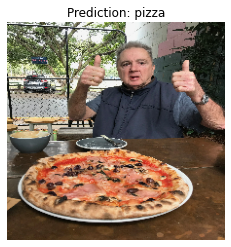

In [ ]:
# Download another test custom image and make a prediction on it
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg

pred_and_plot(model_7,"03-pizza-dad.jpeg")

#Multi-class Image Classification

We've just been through a bunch of the following steps with a binary classification problem (pizza vs steak), now we're going to step things up a notch with 10 classes of food (multi-class classification).

1. Become one with the data
2. Preprocess the data (get it ready for our model)
3. Create a model (start with a baseline)
4. Fit the model (overfit it to make sure it works)
5. Evaluate the model
6. Adjust different hyperparameters and improve the model (try to beat baseline/reduce overfitting)
7. Repeat until satisfied


## 1. Import and become one with the data

In [ ]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

# Unzip our data
zip_ref = zipfile.ZipFile("10_food_classes_all_data.zip")
zip_ref.extractall()
zip_ref.close()


--2022-01-29 13:31:58--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.152.128, 173.194.197.128, 64.233.191.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.152.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   197MB/s    in 2.5s    

2022-01-29 13:32:00 (197 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [ ]:
import os

# Walk through ten classes of food image data
for dirpath,dirnames,filenames in os.walk("10_food_classes_all_data"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.

In [ ]:
# Setup the train and test directories
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

In [ ]:
# Let's get the class names
import pathlib
import numpy as np
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


In [ ]:
import random
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

def view_random_image(target_dir,target_class):
  target_folder = target_dir + target_class
  random_image = random.sample(os.listdir(target_folder),1)
  img = mpimg.imread(target_folder + "/" + random_image[0])

  img2 = plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image Shape: {img.shape}")
  return img2

Image Shape: (384, 512, 3)


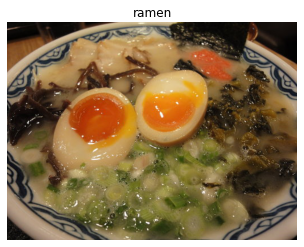

In [ ]:
# Visualize, Visualize, Visualize
import random
img = view_random_image(target_dir=train_dir,
                        target_class=random.choice(class_names))

### 2. Preprocess the data (prepare it for a model)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Rescale
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

# Load data in from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224,224),
                                               batch_size=32,
                                               class_mode="categorical")

test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=(224,224),
                                             batch_size=32,
                                             class_mode = "categorical")

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


### 3. Create a model (start with a baseline)

We've been talking a lot about the CNN Explainer website...how about we just take their model (also on 10 classes) and use it for our problem..?

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Activation

# Create our model (very similar to previous models but actually the same as CNN explainer website)
model_8 = Sequential([
                      Conv2D(10,3,input_shape=(224,224,3)),
                      Activation(activation="relu"),
                      Conv2D(10,3,activation="relu"),
                      MaxPool2D(),
                      Conv2D(10,3,activation="relu"),
                      Conv2D(10,3,activation="relu"),
                      MaxPool2D(),
                      Flatten(),
                      Dense(10, activation="softmax") # changed to have 10 output neurons and softmax activation function
])

model_8.compile(loss="categorical_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

### 4. Fit a model

In [ ]:
# Fit the model
history_8 = model_8.fit(train_data, # now 10 different classes
                        steps_per_epoch = len(train_data),
                        epochs=5,
                        validation_data = test_data,
                        validation_steps=len(test_data))

Epoch 1/5
235/235 [==============================] - 73s 262ms/step - loss: 2.1897 - accuracy: 0.1725 - val_loss: 2.0632 - val_accuracy: 0.2556
Epoch 2/5
235/235 [==============================] - 58s 248ms/step - loss: 1.9970 - accuracy: 0.2916 - val_loss: 1.9448 - val_accuracy: 0.3004
Epoch 3/5
235/235 [==============================] - 62s 262ms/step - loss: 1.7301 - accuracy: 0.4143 - val_loss: 1.8747 - val_accuracy: 0.3420
Epoch 4/5
235/235 [==============================] - 67s 285ms/step - loss: 1.2054 - accuracy: 0.6108 - val_loss: 2.1320 - val_accuracy: 0.3216
Epoch 5/5
235/235 [==============================] - 59s 252ms/step - loss: 0.5868 - accuracy: 0.8124 - val_loss: 2.7985 - val_accuracy: 0.2908


### Evaluate the model

In [ ]:
model_8.evaluate(test_data)

79/79 [==============================] - 14s 177ms/step - loss: 2.7986 - accuracy: 0.2908


[2.7985501289367676, 0.290800005197525]

In [ ]:
def plot_loss_curves(history):
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]
  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]
  epochs = range(len(history.history["loss"]))

  plt.figure()
  plt.plot(epochs,loss,label = "Training Loss")
  plt.plot(epochs,val_loss,label = "Validation Loss")
  plt.title("Loss")
  plt.legend();

  plt.figure()
  plt.plot(epochs,accuracy,label = "Training Accuracy")
  plt.plot(epochs,val_accuracy,label = "Validation Accuracy")
  plt.title("Accuracy")
  plt.legend();

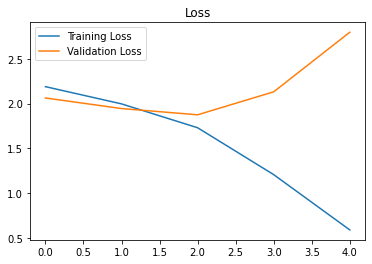

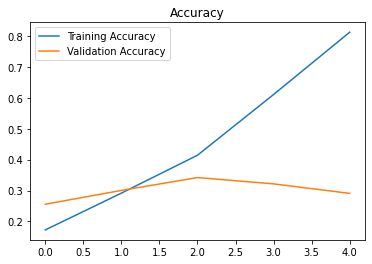

In [ ]:
# Check out the model's loss curves on the 10 classes
plot_loss_curves(history_8)

What do these loss curves tell us?

Well...it seems our model is overfitting the training set quite badly...in other words, it's getting great results on training data but fails to generalize well to unseen data on the test dataset.

### 6. Adjust the model hyperparamaters (to beat the baseline/reduce overfitting)

Due to it's performance on the training data, it's clear our model is learning something...

However, it's not generalizing well to unseen data (overfitting).

So let's try and fix overfitting by...

* **Get more data** - having more data gives a model more opportunity to learn diverse patterns
* **Simplify** - if our current model is overfitting the data, it may be too complicated of a model, some ways to simplify a model is to: reduce # of layers or reduce number of hidden units in layers
* **Use Data Augmentation** - data augmentation manipulates the training data in such a way to add more diversity to it (without altering the original data)
* **Use Transfer Learning** - transfer learning leverages the patterns another model has learned on similar data to your own and allows you to use those patters on your own dataset

In [ ]:
# How about we try and simplify our model first?
# Let's try to remove 2 convolutional layers

model_9 = Sequential([
                      Conv2D(10,3,activation = "relu", input_shape=(224,224,3)),
                      MaxPool2D(),
                      Conv2D(10,3,activation="relu"),
                      MaxPool2D(),
                      Flatten(),
                      Dense(10,activation="softmax")
])

model_9.compile(loss="categorical_crossentropy",
                optimizer = "Adam",
                metrics=["accuracy"])

In [ ]:
model_9.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 111, 111, 10)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 10)      910       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 54, 54, 10)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 29160)             0         
                                                                 
 dense_1 (Dense)             (None, 10)               

In [ ]:
# Fit the model with 2x Conv layers removed
history_9 = model_9.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data = test_data,
                        validation_steps = len(test_data))

Epoch 1/5
235/235 [==============================] - 55s 230ms/step - loss: 2.1565 - accuracy: 0.2312 - val_loss: 1.9474 - val_accuracy: 0.2984
Epoch 2/5
235/235 [==============================] - 55s 235ms/step - loss: 1.8756 - accuracy: 0.3521 - val_loss: 1.8847 - val_accuracy: 0.3328
Epoch 3/5
235/235 [==============================] - 54s 228ms/step - loss: 1.6366 - accuracy: 0.4540 - val_loss: 1.8971 - val_accuracy: 0.3416
Epoch 4/5
235/235 [==============================] - 54s 228ms/step - loss: 1.2870 - accuracy: 0.5831 - val_loss: 1.9800 - val_accuracy: 0.3552
Epoch 5/5
235/235 [==============================] - 54s 229ms/step - loss: 0.8502 - accuracy: 0.7397 - val_loss: 2.2935 - val_accuracy: 0.3184


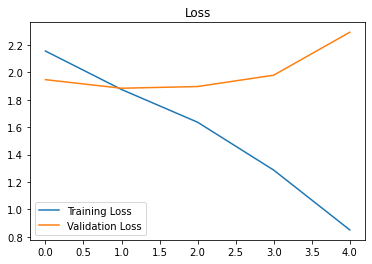

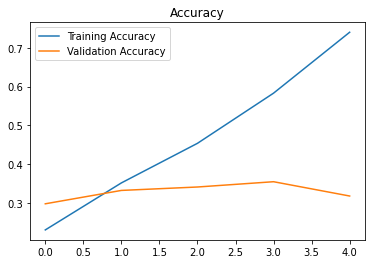

In [ ]:
# check out the loss curves of model_9
plot_loss_curves(history_9)

In [ ]:
model_9.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 111, 111, 10)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 10)      910       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 54, 54, 10)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 29160)             0         
                                                                 
 dense_1 (Dense)             (None, 10)               

In [ ]:
model_8.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 activation (Activation)     (None, 222, 222, 10)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 10)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                        

Looks like our "simpliyfying the model" experiment didnt work...
the accuracy went down and overfitting continued

How about we try data augmentation?

###Trying to reduce overfitting with data augmentation

Let's try and improve our model's results by using augmented training data...

Ideally, we want to:
* Reduce overfitting (get the train and validation loss curves closer)
* Improve validation accuracy

In [ ]:
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=0.2,
                                             shear_range=0.2,
                                             width_shift_range=0.2,
                                             zoom_range=0.2,
                                             horizontal_flip = True)

test_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=0.2,
                                             shear_range=0.2,
                                             width_shift_range=0.2,
                                             zoom_range=0.2,
                                             horizontal_flip = True)

train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                                   target_size=(224,224),
                                                                   class_mode="categorical",
                                                                   batch_size=32,
                                                                   shuffle=True,
                                                                   seed=42)

test_data_augmented = test_datagen_augmented.flow_from_directory(test_dir,
                                                                 target_size=(224,224),
                                                                 class_mode = "categorical",
                                                                 batch_size=32,
                                                                 shuffle=True,
                                                                 seed=42)

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [ ]:
# Let's create another model but this time we'll fit it on the augmented training data
model_10 = tf.keras.models.clone_model(model_8)

# Compile the cloned model (using the same setup as previous models)
model_10.compile(loss="categorical_crossentropy",
                 optimizer = "Adam",
                 metrics= ["accuracy"])

In [ ]:
# Fit the model
history_10 = model_10.fit(train_data_augmented,
                          epochs=5,
                          steps_per_epoch = len(train_data_augmented),
                          validation_data = test_data,
                          validation_steps = len(test_data))

Epoch 1/5
235/235 [==============================] - 140s 593ms/step - loss: 2.2546 - accuracy: 0.1568 - val_loss: 2.1573 - val_accuracy: 0.2148
Epoch 2/5
235/235 [==============================] - 137s 584ms/step - loss: 2.1634 - accuracy: 0.2040 - val_loss: 2.1158 - val_accuracy: 0.2428
Epoch 3/5
235/235 [==============================] - 137s 583ms/step - loss: 2.0750 - accuracy: 0.2673 - val_loss: 1.9440 - val_accuracy: 0.3076
Epoch 4/5
235/235 [==============================] - 136s 580ms/step - loss: 1.9688 - accuracy: 0.3112 - val_loss: 1.8812 - val_accuracy: 0.3360
Epoch 5/5
235/235 [==============================] - 130s 551ms/step - loss: 1.9131 - accuracy: 0.3399 - val_loss: 1.8094 - val_accuracy: 0.3744


In [ ]:
model_8.evaluate(test_data)

79/79 [==============================] - 13s 163ms/step - loss: 2.7986 - accuracy: 0.2908


[2.7985501289367676, 0.290800005197525]

In [ ]:
model_10.evaluate(test_data)

79/79 [==============================] - 13s 163ms/step - loss: 1.8094 - accuracy: 0.3744


[1.809385895729065, 0.37439998984336853]

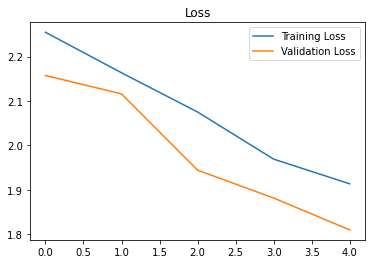

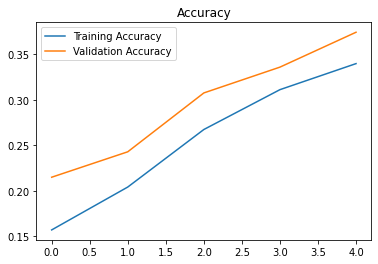

In [ ]:
# Check out our model train on augmented data's loss curves
plot_loss_curves(history_10)

Woah! That looks much better, the loss curves are much closer to each other than the baseline model and they look like they're heading in the right direction (certainly not the wrong direction) so if we were to train for longer, we might see further improvements.

### 7. Repeat Until Satisfied

We could keep going here....contonually trying to bring our loss curves closer together and trying to improve the validation/test accuracy.

How?

By running lots of experiments, namely:
 - restructuring our model's architecture (increasing layers/hidden units)
 - adjust the learning rate
 - try different methods of data augmentation (adjust the hyperparameters in our ImageDataGenerator instance)
 - training for longer (e.g. 10 epochs instead of 5 epochs)
 - try **transfer learning**

### Making a predction with our trained model

In [ ]:
class_names

array(['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon',
       'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi'],
      dtype='<U14')

In [ ]:
# Download some custom images
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-hamburger.jpeg
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-sushi.jpeg

--2022-01-29 14:04:39--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-hamburger.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3564285 (3.4M) [image/jpeg]
Saving to: ‘03-hamburger.jpeg’

03-hamburger.jpeg   100%[===================>]   3.40M  --.-KB/s    in 0.07s   

2022-01-29 14:04:39 (52.0 MB/s) - ‘03-hamburger.jpeg’ saved [3564285/3564285]

--2022-01-29 14:04:39--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting

In [ ]:
# Create a function to import and an image and resize it to be able to be used with our model

def load_and_prep_image(filename,img_shape=224):
  """
  Reads an image from filename, turns it into a tensor and reshapes
   it to (img_shape, img_shape, colour_channels).
   """

   # read in the image
  img = tf.io.read_file(filename)
   # Decode the read file into a tensor
  img = tf.image.decode_image(img)
   # Resize the image
  img = tf.image.resize(img, size = [img_shape,img_shape])
   # Rescale the image (get all values between 0 and 1)
  img = img / 255.
  return img

In [ ]:
# Reconfig pred_and_plot function to work with multi-class images
def pred_and_plot(model,filename,class_names=class_names):
  """
  Imports an image located at filename, makes a prediction with model
  and plots the image with the predicted class as the title
  """

  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # make a prediction
  pred = model.predict(tf.expand_dims(img,axis=0))

  print(len(pred[0]))
  print(tf.argmax(pred))
  
  # Add in logic for multiclass
  if len(pred[0]) > 1:
    pred_class = class_names[tf.argmax(pred[0])]
  else:
    pred_class = class_names[int(tf.round(pred[0]))]

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

10
tf.Tensor([0 0 0 0 0 0 0 0 0 0], shape=(10,), dtype=int64)


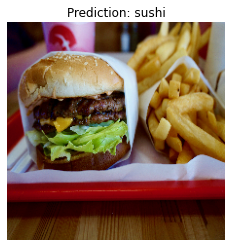

In [ ]:
pred_and_plot(model=model_10,
              filename="03-hamburger.jpeg",
              class_names=class_names)

Looks like our model didn't perform very well on our custom images but this because it only achieved ~39% accuracy on the test data. So we can expect it to function quite poorly on other unseen data

1
tf.Tensor([0], shape=(1,), dtype=int64)


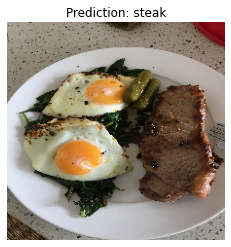

In [ ]:
# Good news: our updated pred_and_plot function works for binary classification too...
pred_and_plot(model=model_3 #trained on pizza vs steak,
              filename="03-steak.jpeg",
              class_names=["pizza","steak"])

## Saving and Loading our Model

In [ ]:
model_10.save("saved_trained_model_10")

INFO:tensorflow:Assets written to: saved_trained_model_10/assets


In [ ]:
# Load in a trained model and evaluate it
loaded_model_10 = tf.keras.models.load_model("saved_trained_model_10")
loaded_model_10.evaluate(test_data)

79/79 [==============================] - 19s 244ms/step - loss: 1.8094 - accuracy: 0.3744


[1.8093863725662231, 0.37439998984336853]

In [ ]:
# Compare our loaded model to our existing model
model_10.evaluate(test_data)

79/79 [==============================] - 29s 366ms/step - loss: 1.8094 - accuracy: 0.3744


[1.809386134147644, 0.37439998984336853]